# Migração sísmica em meios atenuantes
### SENAI CIMATEC
### Autor : Peterson Nogueira

# Migração Sísmica

<p style="line-height: 2.0;">


 - Processamento aplicado aos dados sísmicos que visa obter uma imagem da subsuperfície de uma área de interesse;
    
 - A imagem obtida é conhecida como seção migrada;
    
 - Para que a seção migrada mostre as formas e posições corretas dos refletores em subsuperfície é necessário que a distribuição das propriedades físicas estejam corretas;
    
 - Consiste basicamente em três etapas:
    
     - Propagação do campo de ondas das fontes;
    
     - Propagação do campo de ondas dos receptores;
    
     - Condição de Imagem.

</p>

## Propagação Direta


\begin{equation}
\frac{1}{v^2}\frac{\partial^2 P}{\partial{t^2}} - \nabla^{2}P = f 
\end{equation}

\begin{equation}
\frac{P^{n+1} - 2P^{n} + P^{n-1}} {(v \Delta{t})^2} = (v \Delta{t})^2\nabla^{2}P + (v \Delta{t})^2 f
\label{EQA}
\end{equation}

$$ \color{red}{P^{n+1}} = 2P^{n} - P^{n-1} + (v \Delta{t})^2 \nabla^{2}P + (v \Delta{t})^2 \color{blue}{f} $$



<img src='./pd.png' width=600>


## Propagação Reversa

$$ \color{red}{P^{n-1}} = 2P^{n} - P^{n+1} + (v \Delta{t})^2 \nabla^{2}P + (v \Delta{t})^2 \color{blue}{D(x_{r},t)} $$

<img src='./pr.png' width=600>

## Condição de Imagem

$$I(x,z) = \sum_{N_{s}}\sum_{t=0}^{t_{max}} P_{s}(x,z,t)P_{r}(x,z,t)$$

onde $N_{s}$ é o número de tiros e $t_{max}$ é o tempo máximo de propagação. $P_{s}$ e $P_{r}$ são os campos de onda das fontes e receptores, respectivamente.

<img src='./ci1.png' width=600>

## Resumo

<img src='./ci2.png' width=600>

# Migração Reversa no Tempo (RTM)

<p style="line-height: 2.0;">

A segunda etapa deste curso foca na técnica RTM considerando meios atenuantes, que visa construir uma imagem da subsuperfície mais fidedigna. A RTM é uma das abordagens mais utilizadas na área do imageamento sísmico, por sua capacidade de fornecer detalhes complexos do meio, como interfaces inclinadas e descontinuidades.

Para a execução da RTM, são necessários dois componentes principais:

- Dados de campo (ou dados registrados): Esses dados representam o registro de tiros obtido a partir do modelo $(v,Q)$ verdadeiro. No contexto prático, esses dados são adquiridos no campo. Para simplificar, neste exemplo geraremos dados de campo sintéticos modelando-os com o modelo verdadeiro.

- Modelo $v$ e $Q$ de fundo: Esse modelo é obtido ao processar e inverter os dados de campo. Ele representa uma aproximação da subsuperfície e costuma ser uma versão suavizada do modelo de velocidade verdadeiro. A construção desse modelo será abordada no próximo tutorial, pois depende dos métodos discutidos nesta etapa.
</p>

In [1]:
import numpy as np
import sympy as sp
from devito import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Modelos verdadeiro e modelo de migração

<p style="line-height: 2.0;">

- Criamos os dados observados utilizando o "modelo verdadeiro". 
    
- Também geramos um segundo modelo (modelo de migração) e aplicamos um filtro de suavização, que representa nosso modelo de migração para RTM. 
</p>   

### Definindo os parâmetros do modelo verdadeiro:

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, ModelViscoacoustic, plot_velocity

# Definindo o tamanho do modelo físico
shape = (101, 101)  # Número de pontos da malha (nx, nz)
spacing = (10., 10.)  # Espaçamento, em metros, entre os pontos da malha. 
origin = (0., 0.)  # Localização do canto superior esquerdo?
space_order = 8
nbl = 100


# Definie o modelo de velocidade em km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5


qp = np.zeros(shape)
qp[:] = 3.516*((v[:]*1000.)**2.2)*10**(-6) # Fórmula empírica de Li

rho = np.zeros(shape)
rho[:] = 0.31*(v[:]*1000.)**0.25 # Gardner's relation

### Construindo o model verdadeiro

In [3]:
model = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)

Operator `initdamp` ran in 0.01 s


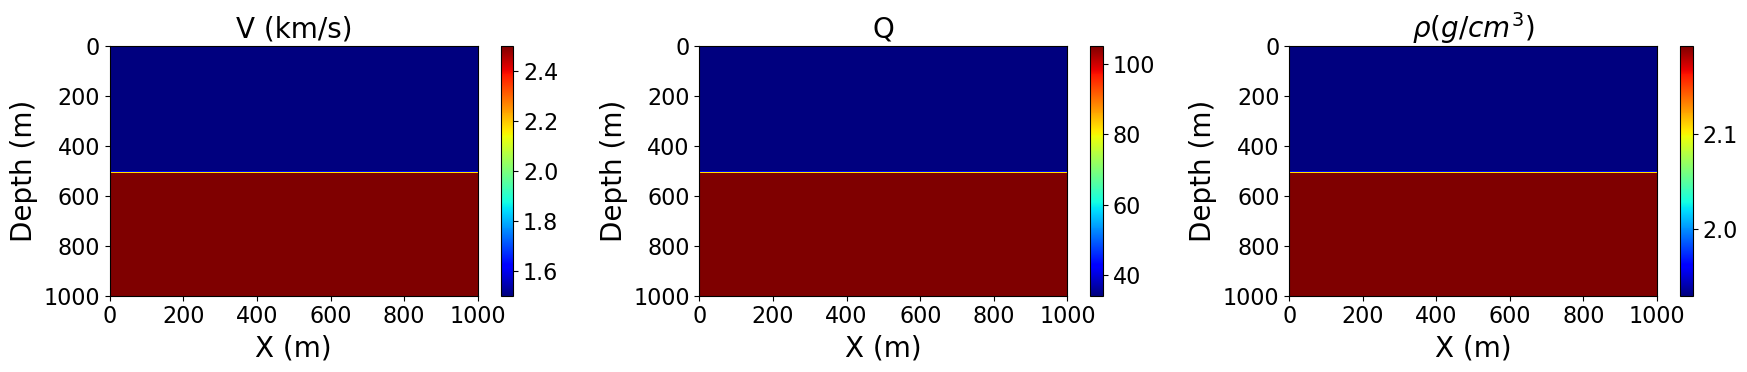

In [4]:
from utils import *
# Plotting Velocity and Q factor model
V_Q_plot(model)

### Construindo o modelo de migração

In [5]:
model0 = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (5, 5)
gaussian_smooth(model0.vp, sigma=filter_sigma)
gaussian_smooth(model0.qp, sigma=filter_sigma)
gaussian_smooth(model0.b, sigma=filter_sigma)

Operator `initdamp` ran in 0.01 s


b(x, y)

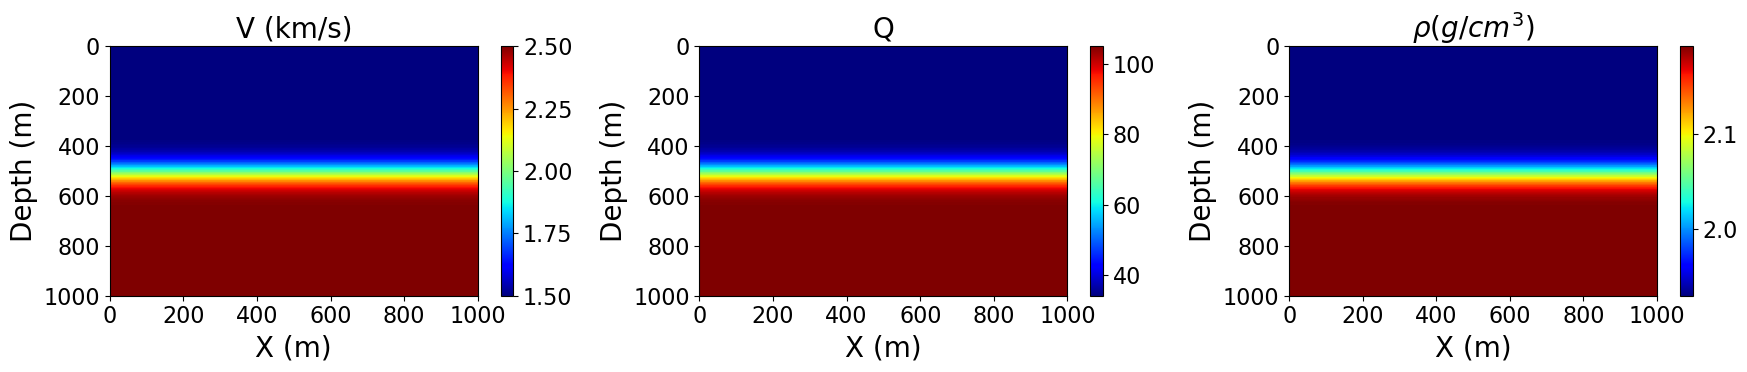

In [6]:
V_Q_plot(model0)

# Geometria de aquisição

<p style="line-height: 2.0;">
    
- Em seguida, definimos o posicionamento e o sinal de onda da nossa fonte, bem como a localização dos nossos receptores;

- Para gerar a wavelet para a nossa fonte, precisamos dos valores discretizados de tempo que usaremos para modelar um único "tiro";

- Para manter a consistência, essa configuração inicial será exatamente como no tutorial de modelagem anterior, embora posteriormente variemos a posição da nossa fonte durante o algoritmo de imageamento real.
    
</p> 

In [7]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulação começa em t=0
tn = 1000.  # Duração da simulação em milisegundos 
dt = model.critical_dt  # passo no tempo 
f0=0.020
time_range = TimeAxis(start=t0, stop=tn, step=dt)

#### Fontes e Receptores

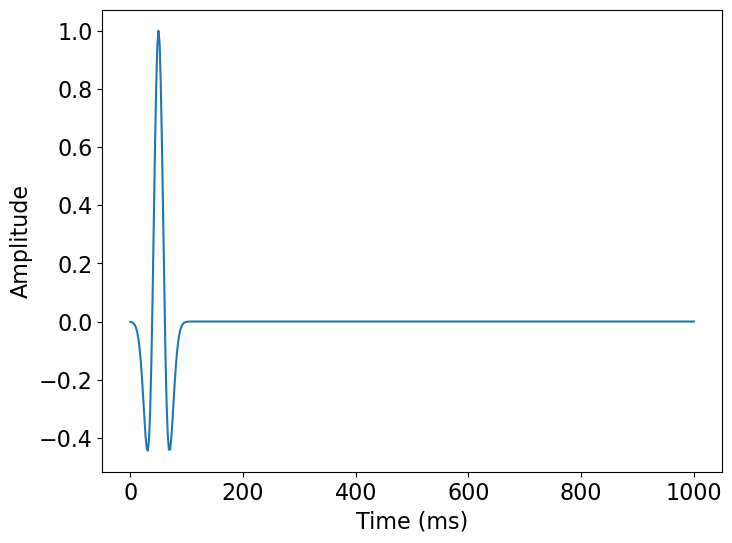

In [8]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 30.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()


# Dado Observado

Agora, podemos gerar os dados observados que serão os dados de entrada da RTM

In [9]:
# Compute synthetic data with forward operator 
from examples.seismic.viscoacoustic import ViscoacousticWaveSolver

In [10]:
solver = ViscoacousticWaveSolver(model, geometry, space_order=space_order, kernel='sls')
d0 = solver.forward(vp=model.vp, qp=model.qp, b=model.b)[0]

Operator `Forward` ran in 0.08 s


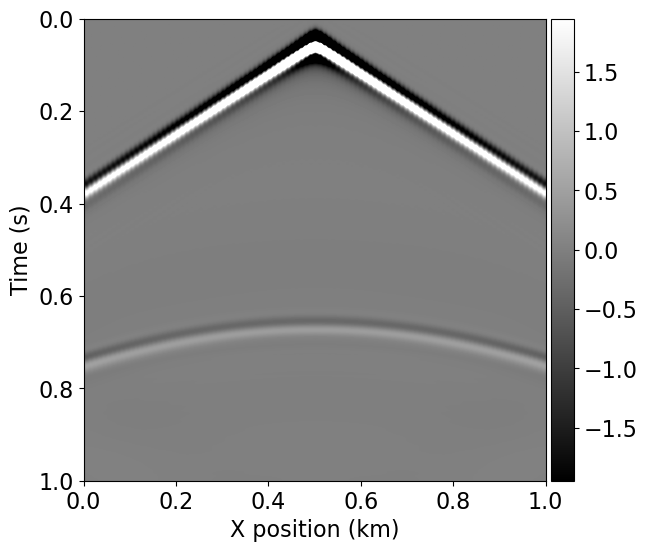

In [11]:
from examples.seismic import plot_shotrecord

plot_shotrecord(d0.data, model, t0, tn)

# Gerando dado observado completo

In [12]:
# Prepare the varying source locations
nshots = 21
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30.

#Gerando o dado SLS
d0 = np.empty((nshots, time_range.num, shape[0]), dtype=np.float32)

for i in range(nshots):
    print('Shot source %d out of %d' % (i+1, nshots))
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    d = solver.forward(vp=model.vp, qp=model.qp, b=model.b, dt=dt)[0]
    d0[i] = d.data[:]
    
    clear_output(wait=True)

Shot source 21 out of 21


Operator `Forward` ran in 0.08 s


# Definindo o Kernel da RTM

In [13]:
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource
from IPython.display import clear_output
from examples.seismic.viscoacoustic.operators import *
from utils import *

kernels = {'sls2': sls_2nd_order,'kv2': kv_2nd_order, 'max2': maxwell_2nd_order, 'acoustic2':acoustic_2nd_order}

def ImagingOperator(model, model0, image, dt, kernel="kv2"):
    
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order, staggered=NODE)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=space_order, 
                     save=time_range.num, staggered=NODE)
    
   
    eq_kernel = kernels[kernel]
    eqn = eq_kernel(model, geometry, v, forward=False)
    
    d0 = PointSource(name='d0', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)   
    
    res_term = d0.inject(field=v.backward, expr=d0 * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)
    
    return Operator([eqn] + res_term + [image_update],
                    subs=model.spacing_map)

In [14]:
from devito import Function

def rtm (kernel, dt):
    # Create image symbol and instantiate the previously defined imaging operator
    image = Function(name='image', grid=model.grid, space_order = space_order)
    op_imaging = ImagingOperator(model, model0, image, dt, kernel=kernel) 

    for i in range(nshots):
        print('Imaging source %d out of %d' % (i+1, nshots))

        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]

        # Compute smooth data and full forward wavefield u0
        u0 = solver.forward(vp=model0.vp, qp=model0.qp, b=model0.b, dt=dt, save=True)[1]

        # Compute gradient from the data residual  
        v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
        
        if kernel!= "acoustic2":
            op_imaging(u=u0, v=v, vp=model0.vp, b=model0.b, qp=model0.qp, dt = dt, d0=d0[i])
        else :
            op_imaging(u=u0, v=v, vp=model0.vp, b=model0.b, dt =dt, d0=d0[i])
            
        
        clear_output(wait=True)
    return image

In [15]:
kernel='acoustic2'
data1 = rtm(kernel, dt)

kernel='sls2'
data2 = rtm(kernel, dt)

kernel='kv2'
data3 = rtm(kernel, dt)

kernel='max2'
data4 = rtm (kernel, dt)
# Plot the inverted image


Imaging source 21 out of 21


Operator `Forward` ran in 0.08 s
Operator `Kernel` ran in 0.08 s


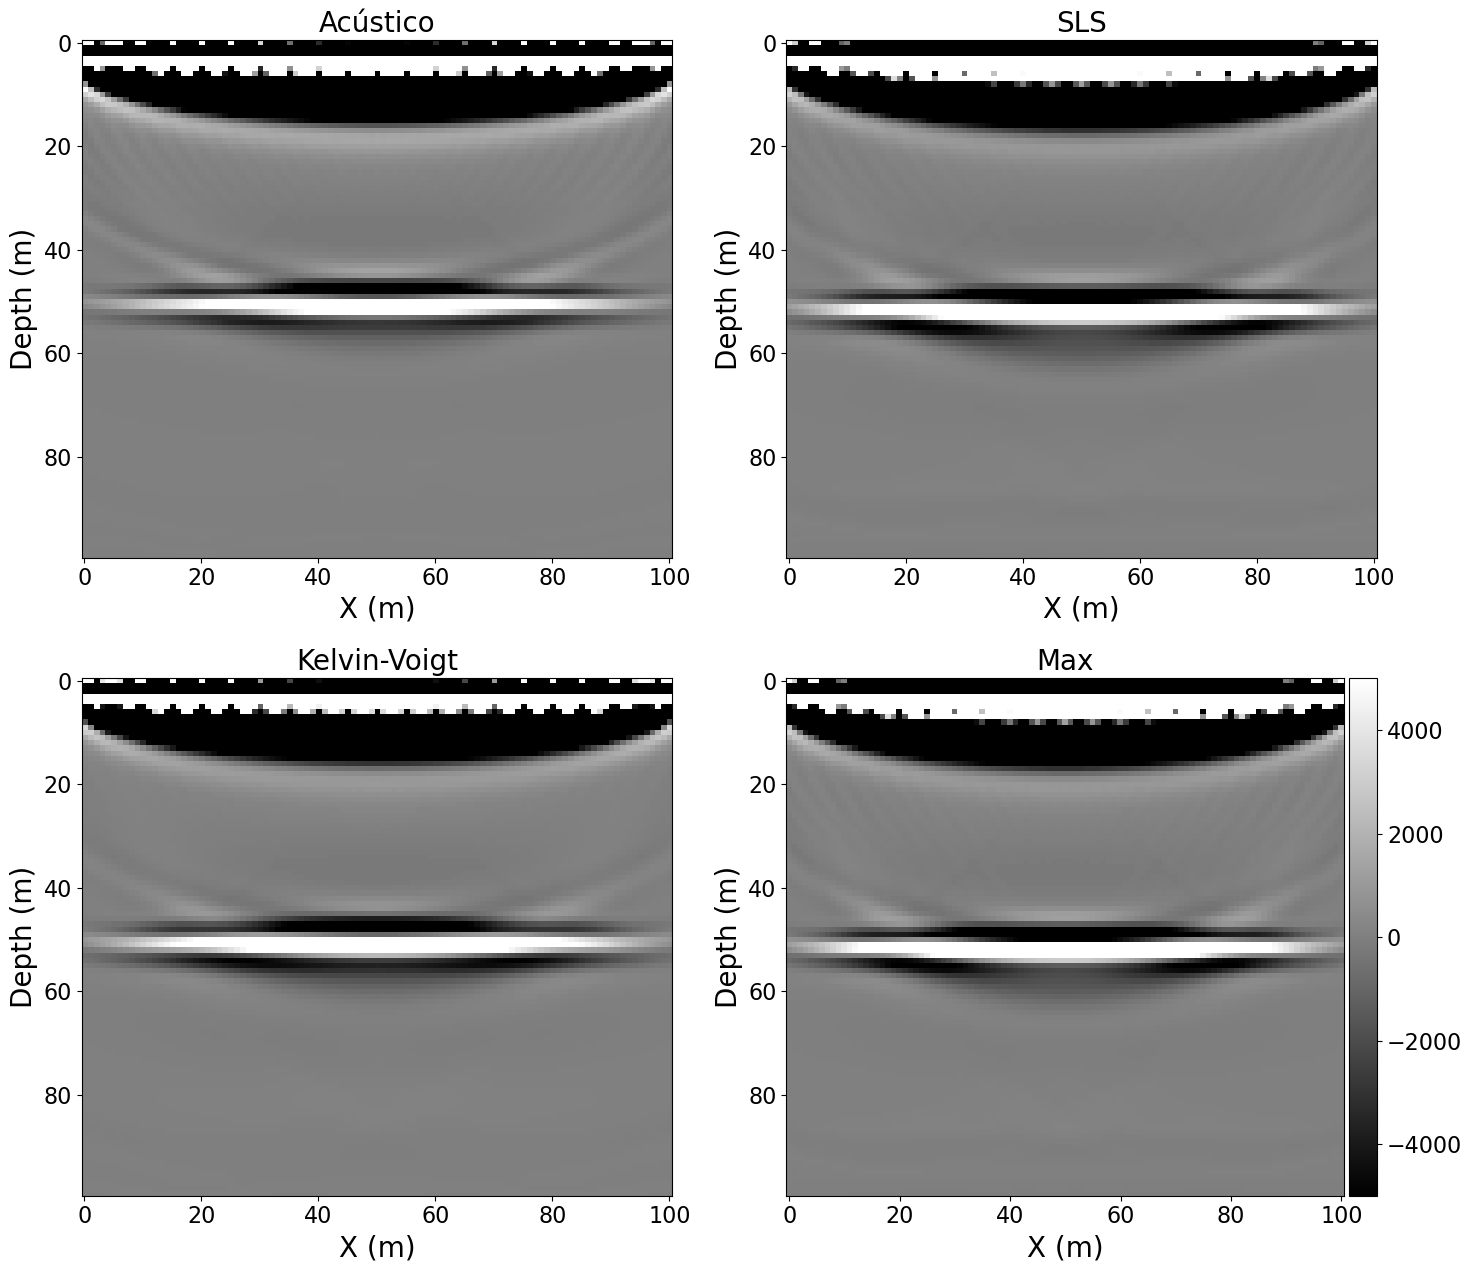

In [16]:
# from utils import *
vmin1=-5.e3; vmax1=5.e3; vmin2=-5.e3; vmax2=5.e3 ;
vmin3=-5.e3; vmax3=5.e3 ; vmin4=-5.e3; vmax4=5.e3 


image_show(model, data1, vmin1, vmax1, data2, vmin2, vmax2, data3, 
           vmin3, vmax3, data4, vmin4, vmax4)

# Chaminé de Gás

Operator `initdamp` ran in 0.01 s


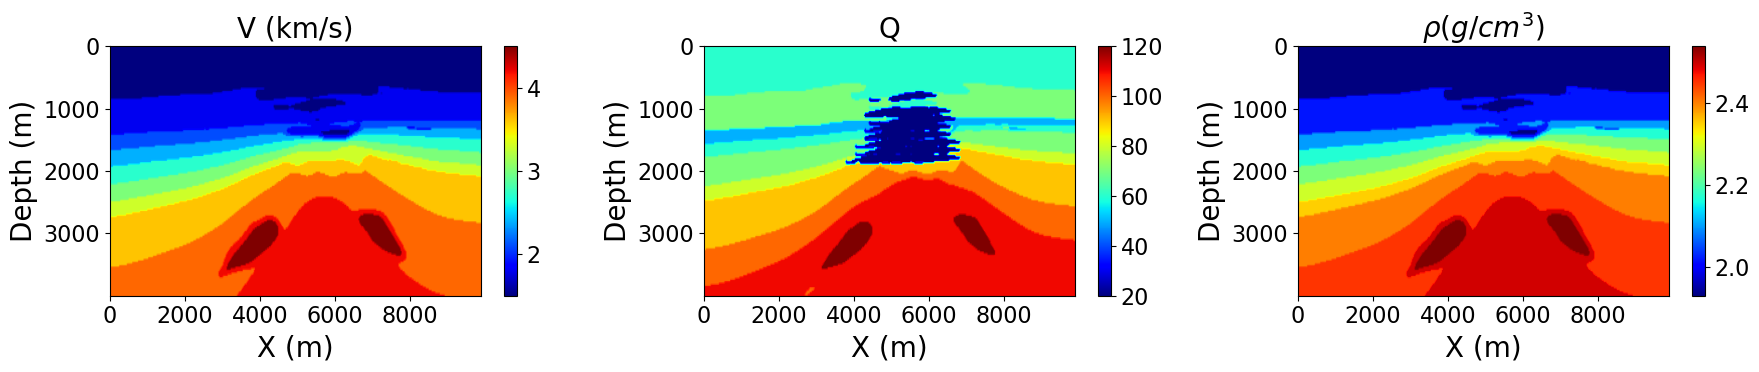

In [17]:
from examples.seismic import (AcquisitionGeometry, TimeAxis, Receiver,  ModelViscoacoustic, setup_geometry, 
                             plot_shotrecord)
nx = 400
nz = 200
shape = (nx, nz)
dtype = np.float32
spacing = (24.8125, 20.1)
origin = (0, 0)
space_order = 16
nbl = 200
pad = 40


v = np.empty(shape, dtype=dtype)
rho = np.empty(shape, dtype=dtype)
qp = np.empty(shape, dtype=dtype)


path="/scratch/projetos/q-rtm-reconcavo/chamine_de_gas/model/"
a = open(path + "V_400x200_chamine.bin", "rb")
v = np.fromfile(a, dtype=dtype, count=nx*nz).reshape([nx, nz])
v = v/1000.
a.close

c = open(path + "Q_400x200_chamine.bin", "rb")
qp = np.fromfile(c, dtype=dtype, count=nx*nz).reshape([nx, nz])
c.close()

rho[:] = 0.31*(v[:]*1000.)**0.25  # Gardner's relation


model = ModelViscoacoustic(vp=v, origin=origin, qp=qp, b=1/rho, shape=shape, spacing=spacing,
                          space_order=space_order, nbl=nbl)

V_Q_plot(model)

Operator `initdamp` ran in 0.01 s


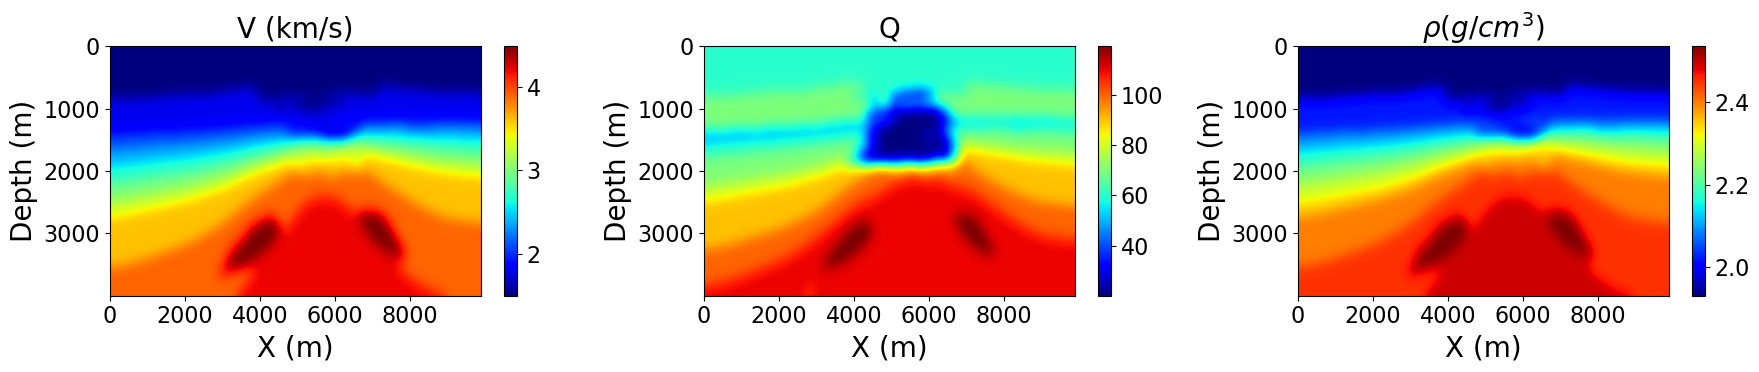

In [18]:
model0 = ModelViscoacoustic(space_order=space_order, vp=v, qp=qp, b=1/rho,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (5, 5)
gaussian_smooth(model0.vp, sigma=filter_sigma)
gaussian_smooth(model0.qp, sigma=filter_sigma)
gaussian_smooth(model0.b, sigma=filter_sigma)

V_Q_plot(model0)

In [19]:
# Time step in ms and time range:
t0, tn = 0., 4000.# initial time and time propagation in ms
# because the 
dt = model.critical_dt*0.7
dt=dt.astype(np.float32)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
f0 = 0.015 # Frequência in kHz.

# Geometria

In [20]:
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 30.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                               t0, tn, f0=f0, src_type='Ricker')
geometry.resample(dt)

Operator `Forward` ran in 1.80 s


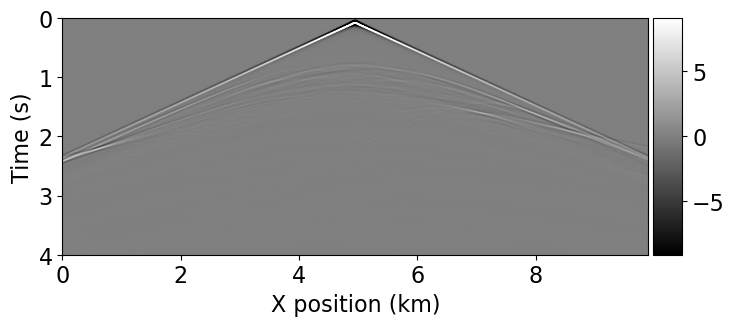

In [21]:
solver = ViscoacousticWaveSolver(model, geometry, space_order=space_order, kernel='sls')
d0 = solver.forward(vp=model.vp, qp=model.qp, b=model.b)[0]

plot_shotrecord(d0.data, model, t0, tn)

# Gerando o dado observado com a equação visco-acústico SLS 

In [22]:
# Prepare the varying source locations
nshots = 5
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., int(model.domain_size[0]), num=nshots)
source_locations[:, 1] = 30.

d0 = np.empty((nshots, time_range.num, shape[0]), dtype=np.float32)

for i in range(nshots):
    print('Shot source %d out of %d' % (i+1, nshots))
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    d = solver.forward(vp=model.vp, qp=model.qp, b=model.b, dt=dt)[0]
    d0[i] = d.data[:]
    
    clear_output(wait=True)
    

Shot source 5 out of 5


Operator `Forward` ran in 2.01 s


In [23]:
kernel='acoustic2'
data1 = rtm (kernel, dt)

kernel='sls2'
data2 = rtm (kernel, dt)

kernel='kv2'
data3 = rtm (kernel, dt)

kernel='max2'
data4 = rtm (kernel, dt)

Imaging source 5 out of 5


Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 1.58 s


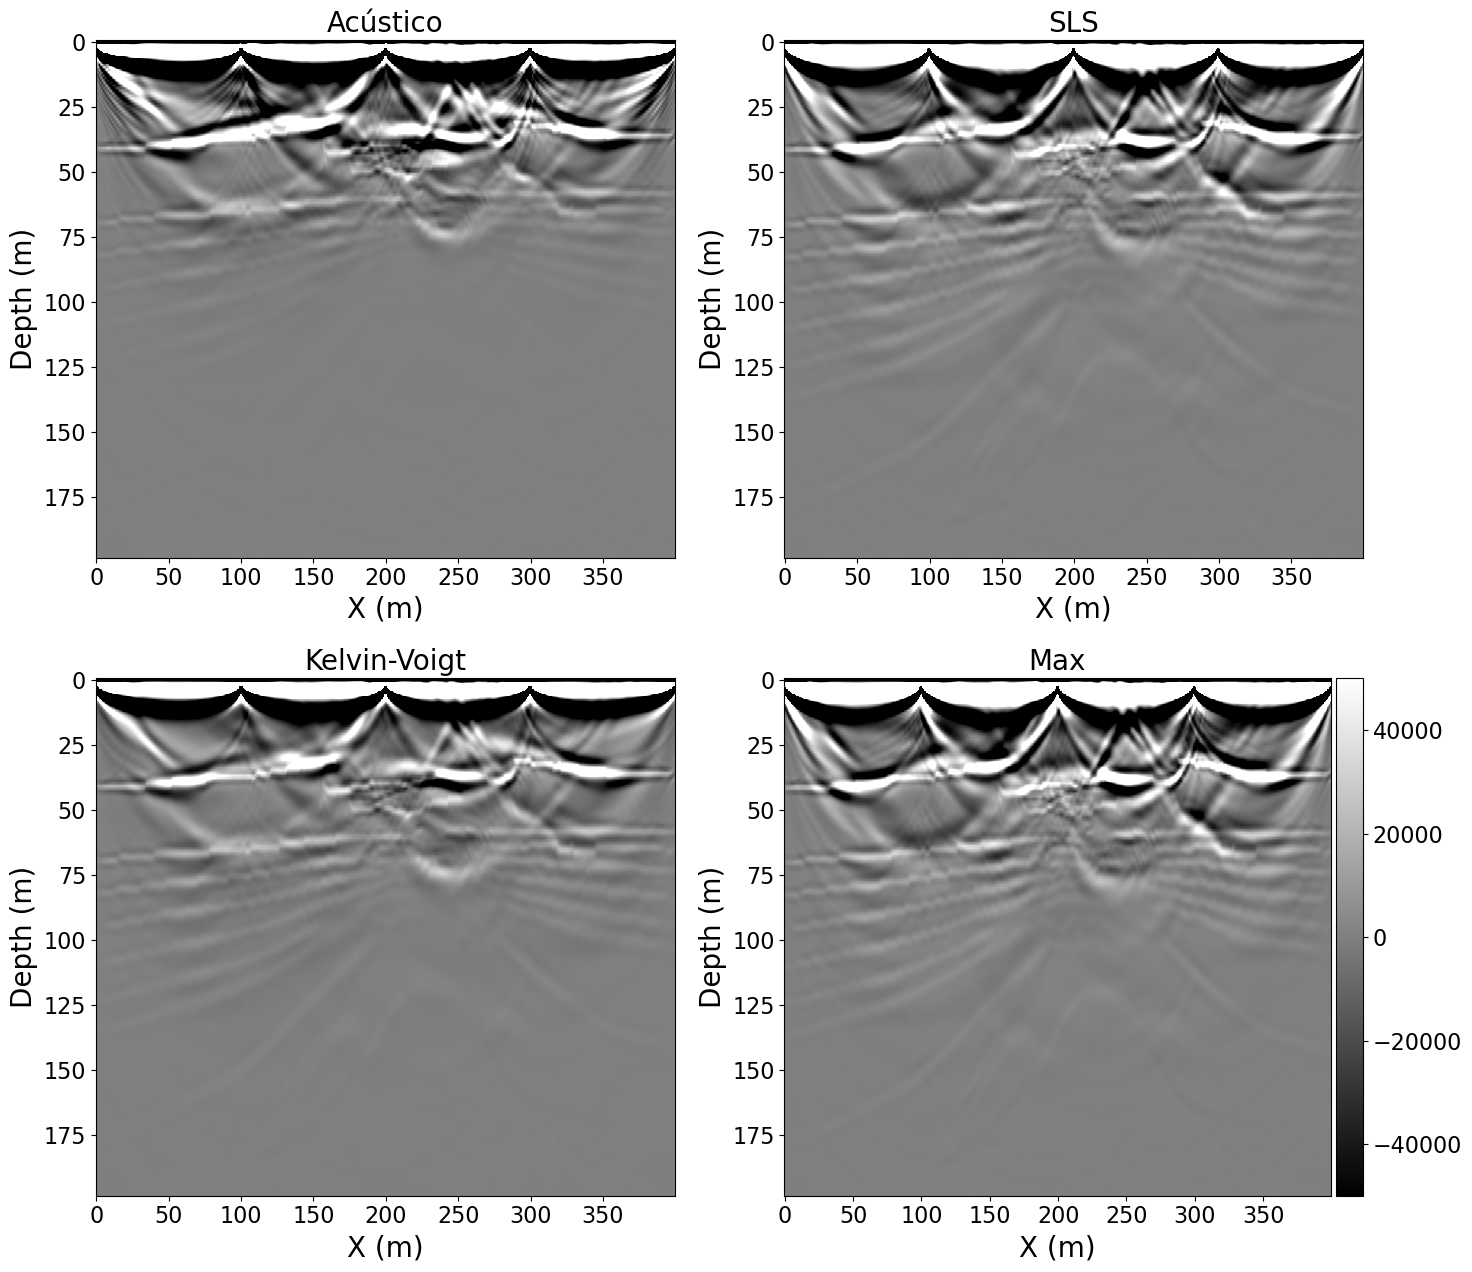

In [24]:
# from utils import *
vmin1=-5.e4; vmax1=5.e4; vmin2=-5.e4; vmax2=5.e4 ;
vmin3=-5.e4; vmax3=5.e4 ; vmin4=-5.e4; vmax4=5.e4 


image_show(model, data1, vmin1, vmax1, data2, vmin2, vmax2, data3, 
           vmin3, vmax3, data4, vmin4, vmax4)